In [2]:
# so we can use packages from parent directory
import sys
sys.path.append("..")

In [37]:
# code copied from example experiments.py
import torch
import torch.nn as nn
import numpy as np
from monroe_data import MonroeData, MonroeDataEntry, Color # last two for reading pkl file
import caption_featurizers
from color_featurizers import ColorFeaturizer, color_phi_fourier
from models import LiteralListener, LiteralSpeaker, ImaginativeListener, CaptionEncoder, CaptionGenerator, ColorGenerator
from evaluation import score_model, delta_e_dist, Speaker, Score
from experiment import FeatureHandler, evaluate_model

In [29]:
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

In [13]:
from functools import partial
import importlib

In [49]:
import evaluation
importlib.reload(evaluation)
from evaluation import score_model, delta_e_dist, Speaker, Score

In [4]:
prefix="../"
train_data = MonroeData(prefix + "data/csv/train_corpus_monroe.csv", prefix + "data/entries/train_entries_monroe.pkl")
dev_data = MonroeData(prefix + "data/csv/dev_corpus_monroe.csv", prefix + "data/entries/dev_entries_monroe.pkl")
dev_data_synth  = MonroeData(prefix + "data/csv/dev_corpus_synth_10fold.csv", prefix + "data/entries/dev_corpus_synth_10fold.pkl")

In [50]:
# 1. Literal Listener
# -----------------------------------------
def literal_listener_experiment(train=False, evaluate=True, composite=False, epochs=5, embed_dim = 100, hidden_dim = 100, color_dim= 54, model_file="../model/literal_listener_5epoch_endings_tkn.params"):

    # Initializing featurizers
    print("Initializing featurizers")
    caption_phi = caption_featurizers.CaptionFeaturizer(tokenizer=caption_featurizers.EndingTokenizer) # Use with parameter files that end in `endings_tkn`
    # caption_phi = caption_featurizers.CaptionFeaturizer(tokenizer=caption_featurizers.WhitespaceTokenizer) # Use with parameter files don't
    color_phi = ColorFeaturizer(color_phi_fourier, "rgb", normalized=True)
    feature_handler = FeatureHandler(train_data, dev_data_synth, caption_phi, color_phi) # target function is initialized by default

    print("Obtaining training features") # get features even if you're runnning the pretrained model for example
    train_features = feature_handler.train_features()
    train_targets = feature_handler.train_targets()

    print("Initializing model")
    model = LiteralListener(CaptionEncoder, num_epochs = epochs)
    model.init_model(embed_dim = embed_dim, hidden_dim = hidden_dim, vocab_size = feature_handler.caption_featurizer.caption_indexer.size,
                 color_dim = color_dim)

    # to train: (probably takes about 15 min - 2 hrs) depending on # of epochs (5 - 30)
    if train:
        print("Training model and saving to {}:".format(model_file))
        model.fit(train_features, train_targets)
        model.save_model(model_file)
    else:
        print("Loading pretrained model")
        model.load_model(model_file)

    if evaluate:
        # convert the model output to a score for that particular round
        print("Evaluating model")
        output_to_score = lambda model_outputs, targets: np.exp(model_outputs[np.arange(len(model_outputs)), targets]) # get the model's predicted probablity at each target index and use that as the score
        if composite:
            my_score_model = partial(score_model, speaker=Speaker.BY_GAME_ID_COND, return_df=True, score=Score.COMPOSITE)
        else:
            my_score_model = partial(score_model, speaker=Speaker.BY_GAME_ID_COND, return_df=True)
        return evaluate_model(dev_data_synth, feature_handler, model, output_to_score, my_score_model, accuracy=False)

Initializing featurizers
Obtaining training features
Initializing model
Loading pretrained model
Evaluating model
((0.8998612831425958, 0.0),           gameid  roundNum  numOutcome condition  model_scores
0        synth-0         1           1     close  1.009972e-01
1        synth-0         2           1     split  9.832635e-01
2        synth-0         3           1       far  5.161063e-06
3        synth-0         4           1     close  6.562652e-01
4        synth-0         5           1     split  1.000000e+00
5        synth-0         6           1       far  9.996920e-01
6        synth-0         7           1     close  1.000000e+00
7        synth-0         8           1     split  1.000000e+00
8        synth-0         9           1       far  1.000000e+00
9        synth-0        10           1     close  9.999990e-01
10       synth-0        11           1     split  9.999795e-01
11       synth-0        12           1     split  9.857901e-01
12       synth-0        13           1 

In [24]:
x = literal_listener_experiment(composite=True)
literal_listener_eval_composite = x[1]
# first get just correlation between all model scores 
ll_true_scores = literal_listener_eval_composite.groupby('gameid').numOutcome.mean()
ll_model_scores = literal_listener_eval_composite.groupby('gameid').model_scores.mean()

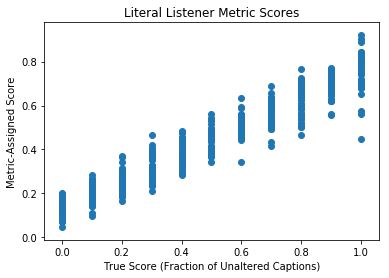

In [31]:
plt.scatter(ll_true_scores, ll_model_scores)
plt.title("Literal Listener Metric Scores")
plt.xlabel("True Score (Fraction of Unaltered Captions)")
plt.ylabel("Metric-Assigned Score")
plt.show()
stats.pearsonr(ll_true_scores, ll_model_scores)

In [30]:
stats.pearsonr(ll_true_scores, ll_model_scores)

(0.9642146069079569, 4.334919406683773e-299)

In [56]:
# now calculate the composite score from the eval_df we get back:
def composite_score(eval_df, speaker="gameid"):
    mean_scores = eval_df.groupby(speaker).numOutcome.mean()
    mean_numCleanWords = eval_df.groupby(speaker).numCleanWords.mean()
    mean_clkTime = eval_df.groupby(speaker).clkTime.mean()
    true_scores = mean_scores / mean_clkTime / mean_numCleanWords
    max_score = true_scores.max()
    true_scores /= max_score # normalize the scores
    return true_scores

ll_true_scores_composite = composite_score(literal_listener_eval_composite)
literal_listener_eval_composite.groupby('gameid').numOutcome.mean()
ll_model_scores_composite = literal_listener_eval_composite.groupby('gameid').model_scores.mean()

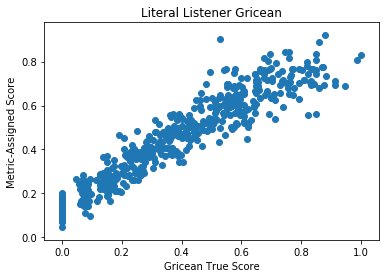

(0.9447046210231533, 1.558182567800219e-251)

In [122]:
plt.scatter(ll_true_scores_composite, ll_model_scores_composite)
plt.title("Literal Listener Gricean")
plt.xlabel("Gricean True Score")
plt.ylabel("Metric-Assigned Score")
plt.show()
stats.pearsonr(ll_true_scores_composite, ll_model_scores_composite)

In [64]:
# separate out conditions
literal_listener_close = literal_listener_eval_composite[literal_listener_eval_composite.condition == "close"]
literal_listener_split = literal_listener_eval_composite[literal_listener_eval_composite.condition == "split"]
literal_listener_far = literal_listener_eval_composite[literal_listener_eval_composite.condition == "far"]

literal_listener_close_true_scores = literal_listener_close.groupby('gameid').numOutcome.mean()
literal_listener_close_model_scores = literal_listener_close.groupby('gameid').model_scores.mean()

literal_listener_split_true_scores =  literal_listener_split.groupby('gameid').numOutcome.mean()
literal_listener_split_model_scores = literal_listener_split.groupby('gameid').model_scores.mean()

literal_listener_far_true_scores =  literal_listener_far.groupby('gameid').numOutcome.mean()
literal_listener_far_model_scores = literal_listener_far.groupby('gameid').model_scores.mean()

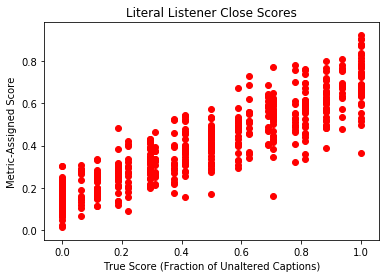

Pearson-r: (0.8855803345622756, 1.228536731197975e-173)


In [71]:
plt.scatter(literal_listener_close_true_scores, literal_listener_close_model_scores, color="red")
plt.title("Literal Listener Close Scores")
plt.xlabel("True Score (Fraction of Unaltered Captions)")
plt.ylabel("Metric-Assigned Score")
plt.show()
print("Pearson-r:",stats.pearsonr(literal_listener_close_true_scores, literal_listener_close_model_scores))

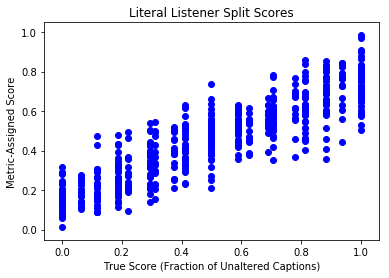

Pearson-r: (0.8895371298048358, 2.4331385411684018e-177)


In [72]:
plt.scatter(literal_listener_split_true_scores, literal_listener_split_model_scores, color="blue")
plt.title("Literal Listener Split Scores")
plt.xlabel("True Score (Fraction of Unaltered Captions)")
plt.ylabel("Metric-Assigned Score")
plt.show()
print("Pearson-r:",stats.pearsonr(literal_listener_split_true_scores, literal_listener_split_model_scores))

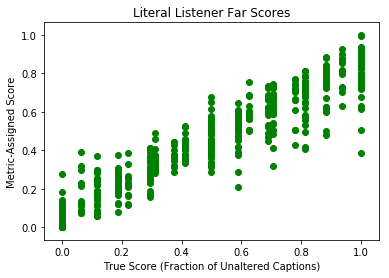

Pearson-r: (0.940358244689538, 2.5482919731241314e-243)


In [73]:
plt.scatter(literal_listener_far_true_scores, literal_listener_far_model_scores, color="green")
plt.title("Literal Listener Far Scores")
plt.xlabel("True Score (Fraction of Unaltered Captions)")
plt.ylabel("Metric-Assigned Score")
plt.show()
print("Pearson-r:",stats.pearsonr(literal_listener_far_true_scores, literal_listener_far_model_scores))

In [69]:
literal_listener_close_composite = composite_score(literal_listener_close)
literal_listener_split_composite = composite_score(literal_listener_split)
literal_listener_far_composite   = composite_score(literal_listener_far)

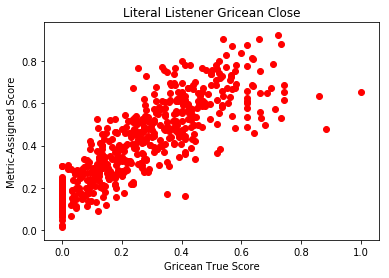

Pearson-r: (0.8222790245743911, 3.519231417012666e-128)


In [121]:
plt.scatter(literal_listener_close_composite, literal_listener_close_model_scores, color="red")
plt.title("Literal Listener Gricean Close")
plt.xlabel("Gricean True Score")
plt.ylabel("Metric-Assigned Score")
plt.show()
print("Pearson-r:",stats.pearsonr(literal_listener_close_composite, literal_listener_close_model_scores))

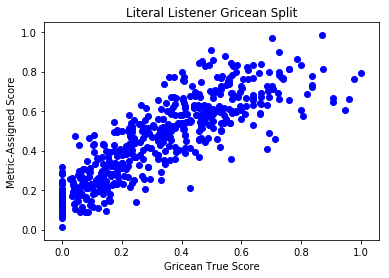

Pearson-r: (0.8470458555881015, 1.8201708716740188e-143)


In [120]:
plt.scatter(literal_listener_split_composite, literal_listener_split_model_scores, color="blue")
plt.title("Literal Listener Gricean Split")
plt.xlabel("Gricean True Score")
plt.ylabel("Metric-Assigned Score")
plt.show()
print("Pearson-r:",stats.pearsonr(literal_listener_split_composite, literal_listener_split_model_scores))

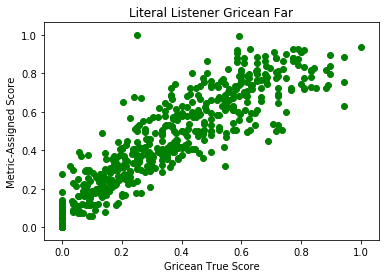

Pearson-r: (0.8928549496715799, 1.4803492474381155e-180)


In [119]:
plt.scatter(literal_listener_far_composite, literal_listener_far_model_scores, color="green")
plt.title("Literal Listener Gricean Far")
plt.xlabel("Gricean True Score")
plt.ylabel("Metric-Assigned Score")
plt.show()
print("Pearson-r:",stats.pearsonr(literal_listener_far_composite, literal_listener_far_model_scores))

# Imaginative Listener

In [85]:
# 4. Imaginative Listener
def imaginative_listener(train=False, model_file="../model/imaginative_listener_with_distractors_linear100hd5epoch_GLOVE_MSE.params"):
    print("Initializing featurizers")
    caption_phi = caption_featurizers.CaptionFeaturizer(tokenizer=caption_featurizers.EndingTokenizer)
    color_phi = ColorFeaturizer(color_phi_fourier, "rgb", normalized=True)

    def target_color_target(data_entry):
        return np.array(data_entry.colors[0].rgb_norm)

    feature_handler = FeatureHandler(train_data, dev_data_synth, caption_phi, color_phi, target_fn=target_color_target,
                                randomized_colors=False)

    print("Obtaining training features") # get features even if you're runnning the pretrained model for example
    train_features = feature_handler.train_features()
    train_targets = feature_handler.train_targets()

    imaginative_model = ImaginativeListener(ColorGenerator, criterion=torch.nn.CosineEmbeddingLoss,
                            optimizer=torch.optim.Adam, lr=0.004, num_epochs=5)

    MSELossSum = lambda: nn.MSELoss(reduction='sum') # sorry for this ugliness..... but this is me passing a parameter to the loss func
    imaginative_model = ImaginativeListener(ColorGenerator, criterion=MSELossSum,
                                optimizer=torch.optim.Adam, lr=0.004, num_epochs=5, use_color=True)
    imaginative_model.init_model(embed_dim=100, hidden_dim=100, vocab_size=feature_handler.caption_featurizer.caption_indexer.size,
                    color_in_dim=54, color_hidden_dim=100, weight_matrix=caption_featurizers.get_pretrained_glove(feature_handler.caption_featurizer.caption_indexer.idx2word.items(), 100, prefix=True))

    if train:
        print("Training model and saving to {}:".format(model_file))
        imaginative_model.fit(train_features, train_targets)
        imaginative_model.save_model(model_file)
    else:
        print("Loading pretrained model")
        imaginative_model.load_model(model_file)

    print("Evaluating model")
    output_to_score_de = lambda outputs, targets: np.array([delta_e_dist(outputs[i], targets[i]) for i in range(len(targets))])
    # we want to score based on the model's predictions at the TARGET indices not listener clicked indices,
    # so we change the feature_handler's target function to do that:
    my_score_model = partial(score_model, speaker=Speaker.BY_GAME_ID_COND, return_df=True, score=Score.COMPOSITE)
    result = evaluate_model(dev_data_synth, feature_handler, imaginative_model, output_to_score_de, my_score_model, accuracy=False)
    
    return result

In [86]:
x = imaginative_listener()
imaginative_listener_eval = x[1]
# first get just correlation between all model scores 
il_true_scores = imaginative_listener_eval.groupby('gameid').numOutcome.mean()
il_model_scores = imaginative_listener_eval.groupby('gameid').model_scores.mean()

Initializing featurizers
Obtaining training features
Loading pretrained model
Evaluating model
Got here to composite score
((-0.22815029598214417, 9.18489275263942e-20),           gameid  roundNum  numOutcome  \
0        synth-0         1           1   
1        synth-0         2           1   
2        synth-0         3           1   
3        synth-0         4           1   
4        synth-0         5           1   
5        synth-0         6           1   
6        synth-0         7           1   
7        synth-0         8           1   
8        synth-0         9           1   
9        synth-0        10           1   
10       synth-0        11           1   
11       synth-0        12           1   
12       synth-0        13           1   
13       synth-0        14           1   
14       synth-0        15           1   
15       synth-0        16           1   
16       synth-0        17           1   
17       synth-0        18           1   
18       synth-0        19      

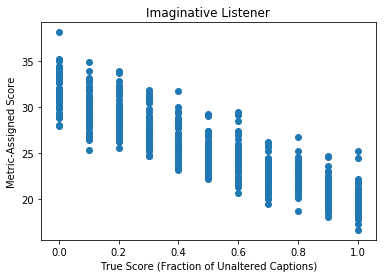

(-0.8924668739410605, 3.5640001295720867e-180)

In [118]:
plt.scatter(il_true_scores, il_model_scores)
plt.title("Imaginative Listener")
plt.xlabel("True Score (Fraction of Unaltered Captions)")
plt.ylabel("Metric-Assigned Score")
plt.show()
stats.pearsonr(il_true_scores, il_model_scores)

In [89]:
# composite
il_true_scores_composite = composite_score(imaginative_listener_eval)

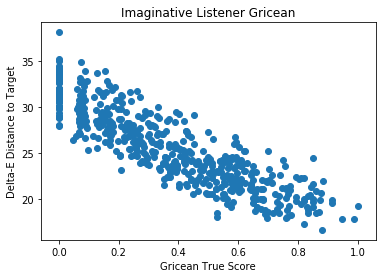

(-0.8709169791904842, 5.109968702007822e-161)

In [117]:
plt.scatter(il_true_scores_composite, il_model_scores)
plt.title("Imaginative Listener Gricean")
plt.xlabel("Gricean True Score")
plt.ylabel("Delta-E Distance to Target")
plt.show()
stats.pearsonr(il_true_scores_composite, il_model_scores)

In [98]:
# separate out conditions
imaginative_listener_close = imaginative_listener_eval[literal_listener_eval_composite.condition == "close"]
imaginative_listener_split = imaginative_listener_eval[literal_listener_eval_composite.condition == "split"]
imaginative_listener_far = imaginative_listener_eval[literal_listener_eval_composite.condition == "far"]

imaginative_listener_close_true_scores = imaginative_listener_close.groupby('gameid').numOutcome.mean()
imaginative_listener_close_model_scores = imaginative_listener_close.groupby('gameid').model_scores.mean()

imaginative_listener_split_true_scores =  imaginative_listener_split.groupby('gameid').numOutcome.mean()
imaginative_listener_split_model_scores = imaginative_listener_split.groupby('gameid').model_scores.mean()

imaginative_listener_far_true_scores =  imaginative_listener_far.groupby('gameid').numOutcome.mean()
imaginative_listener_far_model_scores = imaginative_listener_far.groupby('gameid').model_scores.mean()

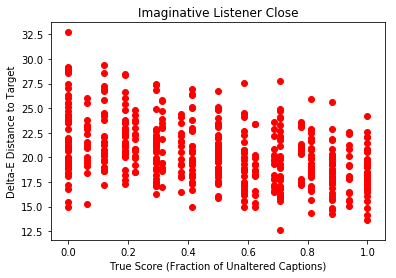

(-0.41266186878356076, 1.1214587076681742e-22)

In [116]:
plt.scatter(imaginative_listener_close_true_scores, imaginative_listener_close_model_scores, color="red")
plt.title("Imaginative Listener Close")
plt.xlabel("True Score (Fraction of Unaltered Captions)")
plt.ylabel("Delta-E Distance to Target")
plt.show()
stats.pearsonr(imaginative_listener_close_true_scores, imaginative_listener_close_model_scores)

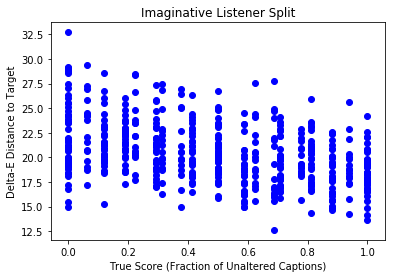

(-0.41148912470034615, 1.5177028781302751e-22)

In [115]:
plt.scatter(imaginative_listener_split_true_scores, imaginative_listener_close_model_scores, color="blue")
plt.title("Imaginative Listener Split")
plt.xlabel("True Score (Fraction of Unaltered Captions)")
plt.ylabel("Delta-E Distance to Target")
plt.show()
stats.pearsonr(imaginative_listener_split_true_scores, imaginative_listener_close_model_scores)

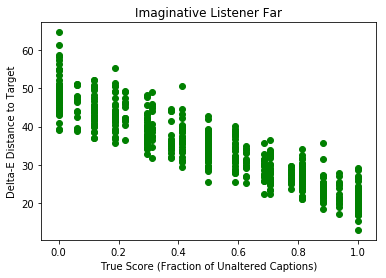

(-0.9110253978358639, 2.807019975030186e-200)

In [114]:
plt.scatter(imaginative_listener_far_true_scores, imaginative_listener_far_model_scores, color="green")
plt.title("Imaginative Listener Far")
plt.xlabel("True Score (Fraction of Unaltered Captions)")
plt.ylabel("Delta-E Distance to Target")
plt.show()
stats.pearsonr(imaginative_listener_far_true_scores, imaginative_listener_far_model_scores)

In [105]:
imaginative_listener_close_true_scores_composite = composite_score(imaginative_listener_close)
imaginative_listener_split_true_scores_composite = composite_score(imaginative_listener_split)
imaginative_listener_far_true_scores_composite   = composite_score(imaginative_listener_far)

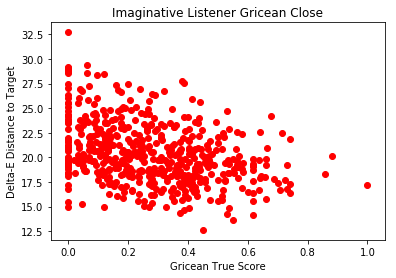

(-0.3541684434969253, 1.0054740992862474e-16)

In [113]:
plt.scatter(imaginative_listener_close_true_scores_composite, imaginative_listener_close_model_scores, color="red")
plt.title("Imaginative Listener Gricean Close")
plt.xlabel("Gricean True Score")
plt.ylabel("Delta-E Distance to Target")
plt.show()
stats.pearsonr(imaginative_listener_close_true_scores_composite, imaginative_listener_close_model_scores)

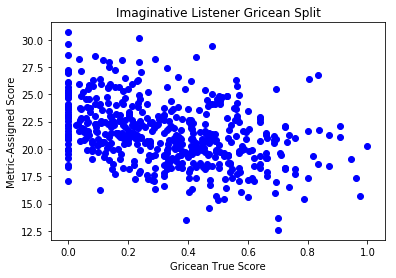

(-0.37349660546179253, 1.4685548875668313e-18)

In [111]:
plt.scatter(imaginative_listener_split_true_scores_composite, imaginative_listener_split_model_scores, color="blue")
plt.title("Imaginative Listener Gricean Split")
plt.xlabel("Gricean True Score")
plt.ylabel("Delta-E Distance to Target")
plt.show()
stats.pearsonr(imaginative_listener_split_true_scores_composite, imaginative_listener_split_model_scores)

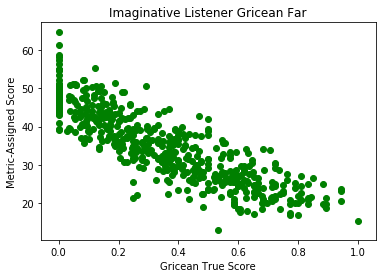

(-0.8566722581820054, 3.690412032566412e-150)

In [110]:
plt.scatter(imaginative_listener_far_true_scores_composite, imaginative_listener_far_model_scores, color="green")
plt.title("Imaginative Listener Gricean Far")
plt.xlabel("Gricean True Score")
plt.ylabel("Delta-E Distance to Target")
plt.show()
stats.pearsonr(imaginative_listener_far_true_scores_composite, imaginative_listener_far_model_scores)

# Pragmatic Listener